## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from scipy.interpolate import interp2d

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 

from  Dataset_Setup import Setup, GaussianCovariance_matrix

In [2]:
from matplotlib import rc

rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)

## Read dataset

In [3]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [4]:
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
parameter_names = c['parameter_names']        
nbidx = 0
print(livetime)

2.154434690031884


In [5]:
parameter_names_1  = set(list(np.array(parameter_names).ravel()))
for p in parameter_names_1:
    print(p)

amplitude
index
lambda_


In [6]:
%%time
dataset_input  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                               livetime = f"{livetime}-hr",
                                        parameters = None)


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-2.154434690031884-hr.fits.gz
CPU times: user 6.1 s, sys: 169 ms, total: 6.27 s
Wall time: 6.29 s


## Datasets

In [7]:
    
setup = Setup(dataset_input=dataset_input)
#setup.set_up_irf_sys(bias, resolution, norm, tilt)
dataset_asimov, dataset_asimov_N = setup.run()
# irf model
setup.set_irf_model(dataset_asimov_N)
if sys == "Eff_area":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 10
    
if sys == "E_reco":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    dataset_asimov_N.irf_model.parameters['norm'].frozen = True
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000
    
    
if sys == "Combined":
    dataset_asimov_N.models.parameters['resolution'].frozen = True
    dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
    dataset_asimov_N.irf_model.parameters['bias'].frozen = False
    dataset_asimov_N.irf_model.parameters['norm'].frozen = False
    setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    e_reco_n = 2000

    
if sys == "BKG":
        
    # piece wise model
    # remove old bkg model
    setup.set_up_bkg_sys_V( breake = 10,
                        index1 = 2,
                        index2 = 1.5, 
                        magnitude = magnitude )

    dataset_asimov, dataset_asimov_N = setup.run()

    setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
    setup.set_piecewise_bkg_model(dataset_asimov_N)
    # energy of the following parameters smaller than ethrshold
    dataset_asimov_N.background_model.parameters['norm0'].frozen = True
    dataset_asimov_N.background_model.parameters['norm1'].frozen = True
    dataset_asimov_N.background_model.parameters['norm2'].frozen = True
    dataset_asimov_N.background_model.parameters['norm3'].frozen = True
    setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
    frozen_pos = 1
    if frozen_pos:
        dataset_asimov.models.parameters['lon_0'].frozen = True
        dataset_asimov.models.parameters['lat_0'].frozen = True
        dataset_asimov_N.models.parameters['lon_0'].frozen = True
        dataset_asimov_N.models.parameters['lat_0'].frozen = True



## Minos

In [8]:
def computing_scan(dataset, note):
        
    fit_cor = Fit(store_trace=False)
    result_cor = fit_cor.run(dataset)
    print(dataset_asimov.models)
    
    results = []
    for parname1 in parameter_names_1 :
        if parname1 == 'index':
            print( parname1)
            dataset.models.parameters[parname1].scan_n_values=numpoints
            result = fit_cor.stat_profile(dataset,
                                 dataset.models.parameters[parname1],
                                reoptimize = True
                                )

            contour_write = dict()
            for k in result.keys():
                print(k)
                if k != "fit_results":
                    contour_write[k] = [float(_) for _ in result[k]]#.tolist()
            print(contour_write)
            with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "w") as outfile:
                yaml.dump(contour_write, outfile, default_flow_style=False)

            results.append(result)
    return results
        
def read_in_scan(note):
    results = []
    for parname1 in parameter_names_1 :
        with open(f"../{c['folder']}/data/4_scan_{note}_{parname1}_{numpoints}.yml", "r") as stream:
            contour = yaml.safe_load(stream)
        results.append(contour)
    return results

In [9]:
%%time
numpoints = 20
computing = 0
if computing:
    results = computing_scan(dataset_asimov, "2.15h")
else:
    results = read_in_scan("2.15h")
    path = f'../{folder}/data/0_model_livetime_{livetime}.yml'
    dataset_asimov.models = Models.read(path)
    


CPU times: user 26.9 ms, sys: 0 ns, total: 26.9 ms
Wall time: 29 ms


In [10]:
%%time
computing = 0
numpoints = 20

if computing:
    dataset_asimov_N.models.parameters['lon_0'].frozen = True
    dataset_asimov_N.models.parameters['lat_0'].frozen = True
    
    results_N = computing_scan(dataset_asimov_N, "N_2.15h")
else:
    results_N = read_in_scan("N_2.15h")
    path = f'../{folder}/data/0_model_nui_livetime_{livetime}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path,bkg_sys = False)        


CPU times: user 163 ms, sys: 47.6 ms, total: 211 ms
Wall time: 214 ms


amplitude
index
lambda_


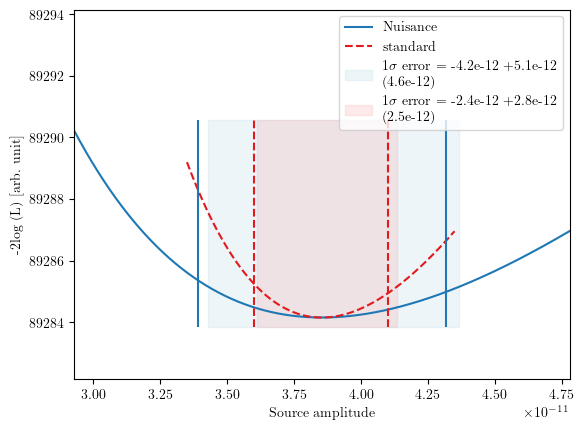

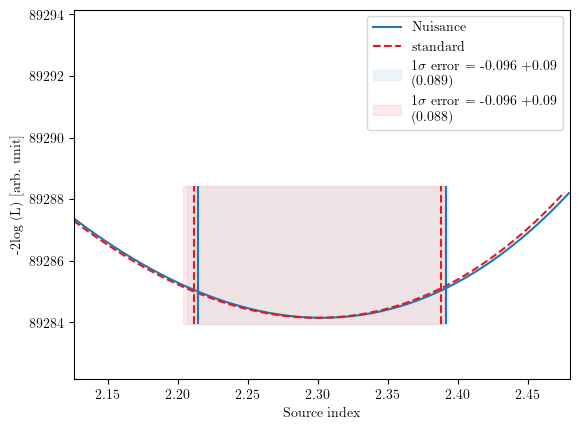

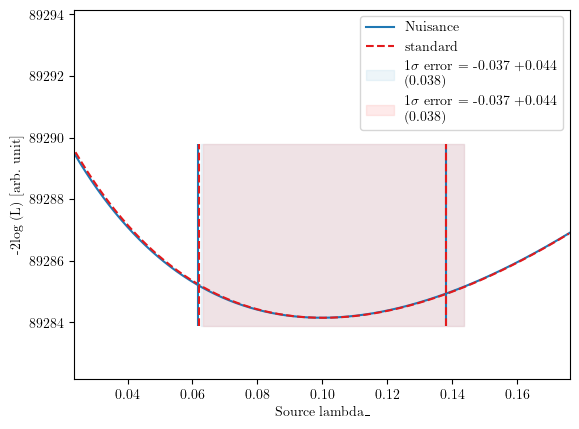

In [11]:
import upper_limit_18_02
for i, p in enumerate(parameter_names_1):
    print(p)
    stat_profile_N = results_N[i]
    stat_profile = results[i]

    fig = plt.figure()
    ll_N_a = stat_profile_N.copy()
    case = 'spectral'
    if p == 'sigma':
        case = 'spatial'
    ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                           name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
    L_N_a, x_N_a = ul_N_a.interpolate()
    plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance", color = aw[0])


    ll_a = stat_profile.copy()
    ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
    L_a, x_a = ul_a.interpolate()
    plt.plot(x_a, L_a(x_a),label = "standard", linestyle = 'dashed', color = awo[0])

    amplitude_err = dataset_asimov.models[0].parameters[p].error
    amplitude = dataset_asimov.models[0].parameters[p].value
    amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
    amplitude_N = dataset_asimov_N.models[0].parameters[p].value



    min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    dataset_asimov_N.models.parameters[p].error_n = er_neg
    dataset_asimov_N.models.parameters[p].error_p = er_pos
    
    
    ax = plt.gca()
    ylim= ax.get_ylim()
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, color = aw[1],
                    label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})')
    ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ylim[1],color = aw[0] )
    ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ylim[1],color = aw[0] )
    nn = 2
    ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
               amplitude_N+amplitude_err_N*nn)
    ax.set_ylim(np.min(stat_profile['stat_scan'])-2,
                np.min(stat_profile['stat_scan'])+ 10)
                
    
    ax.vlines(amplitude-amplitude_err, ylim[0], ylim[1], color = awo[0], linestyle ='dashed')
    ax.vlines(amplitude+amplitude_err, ylim[0], ylim[1], color = awo[0], linestyle ='dashed')
    
    min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
    min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
    dataset_asimov.models.parameters[p].error_n = er_neg
    dataset_asimov.models.parameters[p].error_p = er_pos
    
    ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, color=awo[1],
                    label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})')

    plt.xlabel(f"Source {p} ")
    plt.ylabel("-2log (L) [arb. unit]")
    plt.legend()

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}.pdf")

In [12]:
import colors as s
s.blue

[0.12156862745098039, 0.47058823529411764, 0.7058823529411765]

In [ ]:
import upper_limit_18_02
for i, p in enumerate(parameter_names_1):
    print(p)
    if p == 'amplitude':
    
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "Nuisance", color = aw[0])


        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "standard", linestyle = 'dashed', color = awo[0])

        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value



        min_, er_neg, er_pos = ul_N_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_neg
        dataset_asimov_N.models.parameters[p].error_p = er_pos


        ax = plt.gca()
        ylim= ax.get_ylim()
        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1], alpha = 0.2, color = aw[1],
                        label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err_N:.2})')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ylim[1],color = aw[0] )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ylim[1],color = aw[0] )
        nn = 2
        ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
                   amplitude_N+amplitude_err_N*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-2,
                    np.min(stat_profile['stat_scan'])+ 10)


        ax.vlines(amplitude-amplitude_err, ylim[0], ylim[1], color = awo[0], linestyle ='dashed')
        ax.vlines(amplitude+amplitude_err, ylim[0], ylim[1], color = awo[0], linestyle ='dashed')

        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos

        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ylim[1],  alpha = 0.2, color=awo[1],
                        label = f'1$\sigma$ error = -{er_neg:.2} +{er_pos:.2} \n({amplitude_err:.2})')

        plt.xlabel(f"Source {p} ")
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend()

        fig.savefig(f"../{c['folder']}/plots/4_scan_{p}_advanced.pdf")

amplitude


<Figure size 640x480 with 0 Axes>

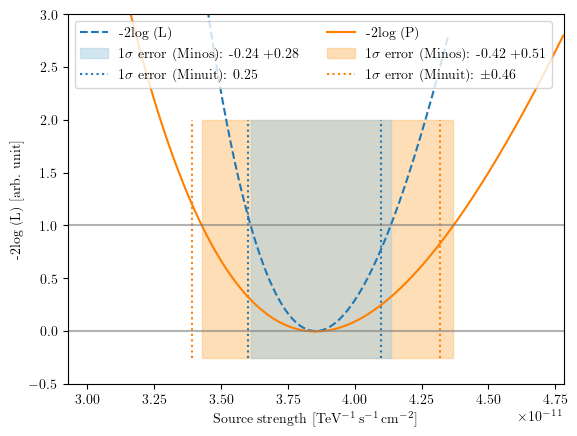

In [29]:
import upper_limit_18_02
for i, p in enumerate(parameter_names_1):
    if p == 'amplitude':
        print(p)
        stat_profile_N = results_N[i]
        stat_profile = results[i]

        stat_profile_N['stat_scan'] -= np.min(stat_profile_N['stat_scan'])
        stat_profile['stat_scan'] -= np.min(stat_profile['stat_scan'])

        fig = plt.figure()
        ll_N_a = stat_profile_N.copy()
        case = 'spectral'
        if p == 'sigma':
            case = 'spatial'
            
        amplitude_err = dataset_asimov.models[0].parameters[p].error
        amplitude = dataset_asimov.models[0].parameters[p].value
        amplitude_err_N = dataset_asimov_N.models[0].parameters[p].error
        amplitude_N = dataset_asimov_N.models[0].parameters[p].value

        fig, ax = plt.subplots(1,1)
            
        ### LIKELIHOOD
        # scan
        ll_a = stat_profile.copy()
        ul_a = upper_limit_18_02.upper_limit(ll_a,0,0,  name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_a, x_a = ul_a.interpolate()
        plt.plot(x_a, L_a(x_a),label = "-2log (L)", linestyle = 'dashed', color = s.blue)
    
        ylim= ax.get_ylim()
        ymax = 2#ylim[1]
        min_, er_neg, er_pos = ul_a.likelihood_error_asymmetric()
        min_ = min_[0]; er_neg = er_neg[0]; er_pos = er_pos[0]; 
        dataset_asimov.models.parameters[p].error_n = er_neg
        dataset_asimov.models.parameters[p].error_p = er_pos

        ax.fill_between(  [np.nan, np.nan], ylim[0], ymax,  alpha = 0.5, color=s.lblue,
                        label = f'1$\sigma$ error (Minos): -{er_neg*1e11:.2} +{er_pos*1e11:.2} ')
     
        
        ax.vlines(amplitude-amplitude_err, ylim[0], ymax, color = s.blue, linestyle ='dotted')
        ax.vlines(amplitude+amplitude_err, ylim[0], ymax, color = s.blue, linestyle ='dotted',
                 label =  f'1$\sigma$ error (Minuit): {amplitude_err*1e11:.2}')

           
        ### POSTERIOR
        # scan
        ul_N_a = upper_limit_18_02.upper_limit(ll_N_a,0,0, 
                                               name=f'{dataset_asimov.models[0].name}.{case}.{p}_scan')
        L_N_a, x_N_a = ul_N_a.interpolate()
        plt.plot(x_N_a, L_N_a(x_N_a),label = "-2log (P)", color = s.orange)
        
        
        min_N, er_negN, er_posN = ul_N_a.likelihood_error_asymmetric()
        min_N = min_N[0]; er_negN = er_negN[0]; er_posN = er_posN[0]; 
        dataset_asimov_N.models.parameters[p].error_n = er_negN
        dataset_asimov_N.models.parameters[p].error_p = er_posN


        ax.fill_between(  [min_N-er_negN, min_N+ er_posN], ylim[0], ymax, alpha = 0.5, color = s.lorange,
                        label = f'1$\sigma$ error (Minos): -{er_negN*1e11:.2} +{er_posN*1e11:.2} ')
        ax.vlines(amplitude_N-amplitude_err_N, ylim[0], ymax,color = s.orange ,
                  linestyles='dotted'
                 )
        ax.vlines(amplitude_N+amplitude_err_N, ylim[0], ymax,color = s.orange,
                  linestyles='dotted',
                    label = f'1$\sigma$ error (Minuit): $\pm${amplitude_err_N*1e11:.2}')
                 
        nn = 2
        ax.set_xlim(amplitude_N-amplitude_err_N*nn, 
                   amplitude_N+amplitude_err_N*nn)
        ax.set_ylim(np.min(stat_profile['stat_scan'])-0.5,
                    np.min(stat_profile['stat_scan'])+ 3)

        
        
        ax.fill_between(  [min_-er_neg, min_+ er_pos], ylim[0], ymax,  alpha = 0.5, color=s.lblue,
                        label = f'')
       
    
    
        xx = ax.get_xlim()
        alpha = 0.6
        ax.hlines(0, xx[0], xx[1], color = 'grey', alpha = alpha)
        ax.hlines(1, xx[0], xx[1], color = 'grey', alpha = alpha)
        str_= "[$\\mathrm{TeV^{-1}\\,s^{-1}\\,cm^{-2}}$]"
        plt.xlabel(f"Source strength " + str_) 
        plt.ylabel("-2log (L) [arb. unit]")
        plt.legend(ncol = 2)

    fig.savefig(f"../{c['folder']}/plots/4_scan_{p}_advanced.pdf")

In [14]:
path = f'../{folder}/data/0_model_nui_livetime_{livetime}_np.yml'
dataset_asimov_N.models.write(path, overwrite = 1)

path = f'../{folder}/data/0_model_livetime_{livetime}_np.yml'
dataset_asimov.models.write(path, overwrite = 1)

In [15]:
print(dataset_asimov.models.parameters['index'].error)
print(dataset_asimov.models.parameters['index'].error_n)
print(dataset_asimov.models.parameters['index'].error_p)
print(dataset_asimov.models.parameters['index'].error)

0.0881668137413857
0.09583988422704826
0.09019532662839991
0.0881668137413857
